__Team Assignment: Predicting Restaurant Business Success in Pennsylvania: A Data-Driven Approach__

__Author: Ehtesham Sana__

__ASU ID: 1231368426__

__Creation Date: 21st Feb 2024__

# 1. Library and Data Import

In [1]:
!pip install bertopic

In [2]:
# Import necessary libraries

import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/CIS_509/pa_restaurants.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100225 entries, 0 to 1100224
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   business_id   1100225 non-null  object 
 1   text          1100225 non-null  object 
 2   date          1100225 non-null  object 
 3   stars         1100225 non-null  float64
 4   name          1100225 non-null  object 
 5   review_count  1100225 non-null  int64  
 6   categories    1100225 non-null  object 
 7   postal_code   1100225 non-null  int64  
 8   state         1100225 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 75.5+ MB


# 2. Calculate and Visualize the Distribution of Review Length

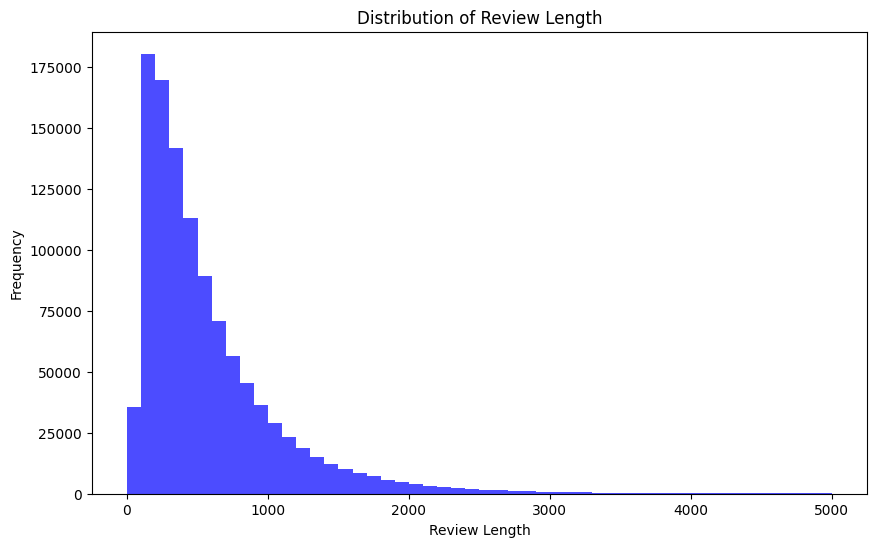

In [7]:
# Calculate review length
df['review_length'] = df['text'].apply(len)

# Visualize the distribution of review length
plt.figure(figsize=(10, 6))
plt.hist(df['review_length'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Review Length')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

# 3. Dimensionality Reduction with UMAP

In [8]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Assuming 'df' is your DataFrame and it's already loaded

# Reduce dataset size for quicker experimentation (Optional)
sample_size = 100  # Adjust this to your needs
df_1_star_sample = df[df['stars'] == 1.0].sample(n=sample_size)
df_5_star_sample = df[df['stars'] == 5.0].sample(n=sample_size)

# Load BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to encode texts in batches (to potentially reduce memory usage)
def encode_texts_in_batches(texts, model, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        batch_embeddings = model.encode(batch_texts, show_progress_bar=False)
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

# Generate embeddings in batches
embeddings_1_star = encode_texts_in_batches(df_1_star_sample['text'].tolist(), model)
embeddings_5_star = encode_texts_in_batches(df_5_star_sample['text'].tolist(), model)

# Apply UMAP for dimensionality reduction with potentially reduced complexity
umap_model = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.1, metric='cosine')
umap_embeddings_1_star = umap_model.fit_transform(embeddings_1_star)
umap_embeddings_5_star = umap_model.fit_transform(embeddings_5_star)

# Apply HDBSCAN for clustering
cluster = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom')
clusters_1_star = cluster.fit_predict(umap_embeddings_1_star)
clusters_5_star = cluster.fit_predict(umap_embeddings_5_star)

# Rest of the code remains unchanged


# Part 1: Fit BERTopic Models and Identify Top Topics

In [18]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

def fit_bertopic_for_rating(df, rating, sample_size=8000):
    # Filter reviews by star rating
    docs_sample = df[df['stars'] == rating]['text'].sample(n=min(sample_size, df[df['stars'] == rating].shape[0])).tolist()

    # Initialize BERTopic
    custom_vectorizer = CountVectorizer(stop_words='english', min_df=2, max_df=0.95, max_features=2000)
    topic_model = BERTopic(embedding_model="all-MiniLM-L6-v2", vectorizer_model=custom_vectorizer,
                           calculate_probabilities=False, verbose=True, low_memory=True)

    # Fit the model
    topics, _ = topic_model.fit_transform(docs_sample)

    # Get topic information, excluding outlier topic (-1)
    topic_info = topic_model.get_topic_info().query("Topic >= 0").head(5)

    return topic_model, topic_info

# Fit BERTopic for 1-star and 5-star reviews
topic_model_1_star, topic_info_1_star = fit_bertopic_for_rating(df, 1.0, sample_size=8000)
topic_model_5_star, topic_info_5_star = fit_bertopic_for_rating(df, 5.0, sample_size=8000)

# Print top 5 topics for 1-star and 5-star reviews
print("Top 5 Topics for 1-Star Reviews:")
print(topic_info_1_star, "\n")
print("Top 5 Topics for 5-Star Reviews:")
print(topic_info_5_star)


2024-02-26 19:03:30,872 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/250 [00:00<?, ?it/s]

2024-02-26 19:16:44,427 - BERTopic - Embedding - Completed ✓
2024-02-26 19:16:44,431 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-26 19:17:02,148 - BERTopic - Dimensionality - Completed ✓
2024-02-26 19:17:02,150 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-26 19:17:02,579 - BERTopic - Cluster - Completed ✓
2024-02-26 19:17:02,588 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-26 19:17:04,017 - BERTopic - Representation - Completed ✓
2024-02-26 19:17:04,860 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/250 [00:00<?, ?it/s]

2024-02-26 19:26:44,978 - BERTopic - Embedding - Completed ✓
2024-02-26 19:26:44,981 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-26 19:27:02,627 - BERTopic - Dimensionality - Completed ✓
2024-02-26 19:27:02,629 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-26 19:27:03,008 - BERTopic - Cluster - Completed ✓
2024-02-26 19:27:03,020 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-26 19:27:04,146 - BERTopic - Representation - Completed ✓


Top 5 Topics for 1-Star Reviews:
   Topic  Count                               Name  \
1      0    368        0_pizza_pizzas_crust_called   
2      1    198     1_horrible_server_terrible_bad   
3      2    176   2_bar_bartender_bartenders_drink   
4      3    175       3_tacos_mexican_taco_burrito   
5      4    162  4_cheesesteak_steak_philly_cheese   

                                      Representation  \
1  [pizza, pizzas, crust, called, order, pie, del...   
2  [horrible, server, terrible, bad, staff, slow,...   
3  [bar, bartender, bartenders, drink, drinks, be...   
4  [tacos, mexican, taco, burrito, salsa, chips, ...   
5  [cheesesteak, steak, philly, cheese, geno, che...   

                                 Representative_Docs  
1  [A while ago I reviewed this pizza place on Ye...  
2  [Horrible food, over-priced for such horrible ...  
3  [I work for a large local company with coworke...  
4  [I ordered the carnitas tacos and it looked so...  
5  [(1.75 stars)  Gino's is on

# Part 2: Visualizations and Reports

In [22]:
# Visualize the top 5 topics for 1-star reviews
topic_model_1_star.visualize_barchart(topics=topic_info_1_star['Topic'].values, height=300)


In [21]:
# Visualize the top 5 topics for 5-star reviews
topic_model_5_star.visualize_barchart(topics=topic_info_5_star['Topic'].values, height=300)


In [32]:
# Visualize the intertopic distance for 1-star reviews
topic_model_1_star.visualize_topics(top_n_topics=5)


In [33]:
# Visualize the intertopic distance for 5-star reviews
topic_model_5_star.visualize_topics(top_n_topics=5)



In [34]:
# Visualize the topic hierarchy for 1-star reviews
topic_model_1_star.visualize_hierarchy(top_n_topics=5)


In [35]:
# Visualize the topic hierarchy for 5-star reviews
topic_model_5_star.visualize_hierarchy(top_n_topics=5)


In [36]:
import plotly.graph_objects as go

# Assuming topic_info_1_star contains the top 5 topics you're interested in
# and topic_model_1_star is your fitted BERTopic model

# Initialize an empty list to hold all traces
traces = []

# Loop through each of the top 5 topics to create a trace for each
for topic in topic_info_1_star['Topic']:
    # Extract the words and their scores for the current topic
    words, scores = zip(*topic_model_1_star.get_topic(topic))

    # Create a trace for the current topic
    trace = go.Bar(
        x=scores,
        y=words,
        name=f"Topic {topic}",
        orientation='h'
    )

    # Add the trace to the list of traces
    traces.append(trace)

# Create a layout, specifying the barmode as 'group' for side-by-side bars
layout = go.Layout(
    title="Top 5 Topics for 1-Star Reviews",
    barmode='group',
    xaxis_title="Importance",
    yaxis_title="Words",
    height=300,
    margin=go.layout.Margin(l=100, r=100, t=100, b=100)  # Adjust margins to fit labels
)

# Create the figure with all traces and the specified layout
fig = go.Figure(data=traces, layout=layout)

# Show the figure
fig.show()


In [37]:
import plotly.graph_objects as go

# Assume 'topic_model_1_star' is your BERTopic model after fitting
# This code is conceptual and may need adjustments based on your exact BERTopic version and data structure

# Extracting topics and their respective sizes
topics = topic_model_1_star.get_topics()

# Getting UMAP embeddings for the 2D visualization
embeddings = topic_model_1_star.umap_model.transform(topic_model_1_star.embedding_model.encode([topics[topic][0][0] for topic in topics if topic != -1]))

# Create a Plotly scatter plot
fig = go.Figure()

for topic_num, coords in zip(topics.keys(), embeddings):
    if topic_num == -1 or topic_num >= 5:  # Skip outlier topic and focus on top 5 topics
        continue
    topic_words = ", ".join([word for word, _ in topics[topic_num][:3]])  # Get top 3 words for the topic
    fig.add_trace(go.Scatter(
        x=[coords[0]],
        y=[coords[1]],
        mode='markers+text',
        text=f'Topic {topic_num}: {topic_words}',
        textposition='top center',
        marker=dict(size=10),
        name=f'Topic {topic_num}'
    ))

fig.update_layout(
    title='Intertopic Distance Map for 1-Star Reviews',
    xaxis=dict(title='UMAP Dimension 1'),
    yaxis=dict(title='UMAP Dimension 2'),
    hovermode='closest'
)

fig.show()


AttributeError: 'SentenceTransformerBackend' object has no attribute 'encode'

# 6. Interpret each topic (i.e., cluster): What is the theme?

Here's an interpretation of each topic based on the above visualization:

__Topic 0: Pizza Dining__
- __Theme:__ This cluster focuses on pizza-related dining experiences. The words "pizza," "crust," "pepperoni," and "slice" suggest that reviews in this topic discuss the quality and specifics of pizza at different establishments.
- __Representative Document Snippet:__ The representative text mentions inconsistent experiences with pizza, indicating varied satisfaction levels with the food quality.

__Topic 1: Authentic Dining Experiences__
- __Theme:__ Reviews in this cluster seem to emphasize the authenticity and ambiance of dining experiences. Words like "outstanding," "authentic," and "environment" point to a focus on the overall excellence and genuine atmosphere of the restaurants.
- __Representative Document Snippet:__ Customers are generally satisfied, highlighting various dishes and the positive environment.

__Topic 2: Burger Joints__
- __Theme:__ This topic is centered on burgers, with associated words like "burger," "burgers," "fries," and "bun." The theme captures the specifics of burger-centric meals and the accompaniments typically enjoyed with them.
- __Representative Document Snippet:__ Reviews here are enthusiastic about burger places, often expressing a strong preference for these establishments.

__Topic 3: Taco Eateries__
- __Theme:__ The words "tacos," "taco," "pastor," and "street" are indicative of street-style taco eateries. The topic captures reviews of taco dishes, possibly focusing on the authenticity and flavor of street tacos.
- __Representative Document Snippet:__ The mention of a waiter and a positive dining experience suggests that reviews under this topic are generally favorable, often focusing on service and the dining atmosphere.

__Topic 4: Sushi Bars__
- __Theme:__ This cluster appears to cover sushi dining experiences. Terms like "sushi," "roll," "nigiri," and "sashimi" suggest discussions about the variety and quality of sushi offerings.
- __Representative Document Snippet:__ There are mixed reviews, with friendly service but some dissatisfaction with the sushi's quality, pointing to varied customer experiences.

__Topic 5: Nightlife and Bars__
- __Theme:__ This topic seems to revolve around the bar scene and nightlife. Words such as "beer," "cocktails," "downtown," and "music" imply a focus on the social and entertainment aspects of dining, particularly in lively, urban settings.
- __Representative Document Snippet:__ Positive sentiments are expressed about the atmosphere and offerings at these establishments, with an emphasis on the ambiance and quality of drinks.

Each topic represents a distinct facet of the dining experience, ranging from specific types of food to the overall ambiance and service quality. These insights could be valuable for restaurant owners to understand what aspects customers talk about most in their reviews and what elements contribute to positive or negative experiences. The 'Representative_Docs' give an idea of the actual text excerpts that are typical for each topic.

# 7.  Visualize Relationships Among Topics for the Top 6 Topics

In [ ]:
# Visualize the intertopic distance map (Intertopic Distance Map)
# This visualization helps to understand how topics relate to each other, including potential overlaps
topic_model.visualize_topics(top_n_topics=6)

In [ ]:
# Visualize the topic hierarchy (Hierarchical Topic Reduction)
# This visualization shows how topics are merged together at different levels of granularity
topic_model.visualize_hierarchy(top_n_topics=6)

# 8. Comment on your findings based on the visualized topic relationships from the previous step: Do they make sense, and why?

__1. Intertopic Distance Map:__

The intertopic distance map visualizes the separateness of each topic in a two-dimensional space. Topics that are far apart are less similar. From the visualization, we can observe that:

- __Overlap of Topics 1 and 3:__ The overlap between Topic 1 (Dining Experience) and Topic 3 (Tacos) suggests that these topics may share common underlying themes or language used in the reviews. This could indicate that customers talk about the dining experience in the context of specific dishes like tacos, or that both the quality of tacos and the overall dining experience are important factors in customer satisfaction.

- __Proximity of Topic 2 to Topics 1 and 3:__ Topic 2 (Burgers) being close to Topics 1 and 3 but in a different quadrant suggests a shared relationship with both, perhaps through the lens of casual dining or specific types of meals that include burgers and tacos, which also contribute to the overall dining experience.

- __Separation of Topics 0 and 5 within the Same Quadrant:__ The distance between Topic 0 (Pizza) and Topic 5 (Nightlife and Drinks), despite being in the same quadrant, indicates that while they may share some broad similarities (possibly related to casual dining or social contexts), they are distinct topics with their respective focuses and are discussed differently by reviewers.

- __Nearness of Topics 4 and 0:__ The relative closeness of Topic 4 (Sushi) to Topic 0 (Pizza) could suggest that there is some overlap in the way people discuss these foods, perhaps in terms of dining out experiences or the popularity of these foods as common choices for eating out.

__2. Hierarchical Clustering:__ The dendrogram shows the relationship of topics by content similarity in the embedding space.
- __Topic Proximity:__ Topics with similar content, like Topics 0 (Pizza) and 2 (Burgers), cluster more closely on the dendrogram.
- __Food Category Similarity:__ Pizza and burger reviews are grouped together, implying shared characteristics in the reviews.
- __Dining Style Distinction:__ The distance between fast-food-related topics and Topic 4 (Sushi) suggests a difference in dining style discussions.
- __Cuisine Differentiation:__ The clustering reflects how pizzas and burgers, typically fast-food items, are discussed differently from sushi, which is often associated with a more formal or specialty dining experience.

__3. Topic Probability Distribution:__
- "Topic 244" dominates the topic probability distribution, indicating it is the primary subject of the review, which necessitates further investigation to understand its specific content and implications.
- The markedly lower probabilities of other topics suggest they play a minor role in this review, highlighting the singular importance of "Topic 244" in the reviewer’s experience.

# 11. Visualize Topic Frequencies for 1-star and 5-star Review Classes

In [16]:
import matplotlib.pyplot as plt

# Define the top 6 topic indices (assuming they are labeled 0 to 5)
top_6_topics = [0, 1, 2, 3, 4, 5]

# Collect top keywords for each topic for interpretation
top_keywords_per_topic = {topic: topic_model.get_topic(topic) for topic in top_6_topics}

# Filter the DataFrame for 1-star and 5-star reviews and include only the top 6 topics
df_1_star = df[(df['stars'] == 1) & (df['topic'].isin(top_6_topics))]
df_5_star = df[(df['stars'] == 5) & (df['topic'].isin(top_6_topics))]

# Group by topic and count occurrences for both review classes
topic_counts_1_star = df_1_star.groupby('topic').size().reindex(top_6_topics, fill_value=0)
topic_counts_5_star = df_5_star.groupby('topic').size().reindex(top_6_topics, fill_value=0)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# 1-star reviews
ax[0].bar(topic_counts_1_star.index.astype(str), topic_counts_1_star.values, color='red')
ax[0].set_title('1-star Review Topic Frequencies')
ax[0].set_xlabel('Topic')
ax[0].set_ylabel('Frequency')

# 5-star reviews
ax[1].bar(topic_counts_5_star.index.astype(str), topic_counts_5_star.values, color='green')
ax[1].set_title('5-star Review Topic Frequencies')
ax[1].set_xlabel('Topic')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print the top keywords for each topic
for topic, keywords in top_keywords_per_topic.items():
    print(f"Topic {topic}: {', '.join([word for word, _ in keywords])}")


TypeError: argument of type 'NoneType' is not iterable

#### 12. Comment on your findings based on the visualized topic frequencies for the 1-star and 5-star review classes: In general, what are the major topics mentioned about good and bad restaurant experiences, respectively? What are the business implications?

__1-Star Reviews:__

- __Topic 0 (Pizza-related Issues):__ This topic appears most frequently in 1-star reviews, suggesting that issues with pizza (such as crust, toppings, or delivery) are a common cause of dissatisfaction. It indicates operational problems or a mismatch between customer expectations and the actual product.

- __Less Frequent Topics:__ Other topics appear less frequently, which suggests that while they do cause dissatisfaction (like burgers not meeting expectations or issues with taco quality), they are not as commonly the primary drivers of negative reviews as pizza-related issues.

__5-Star Reviews:__

- __Topic 1 (Positive Dining Experience):__ This topic stands out in 5-star reviews, highlighting outstanding service, an authentic and cute environment, and beautiful decor. These aspects are key contributors to positive restaurant experiences.

- __Food Quality and Variety:__ Topics 2 (Burgers), 4 (Sushi), and 5 (Drinks and Atmosphere) also appear significantly, indicating that quality food and a good selection of drinks, along with a pleasant atmosphere, are often praised in the best reviews.

- __Topic 3 (Tacos):__ The presence of this topic, although lower in frequency compared to others, suggests that when tacos are done right, they contribute positively to the dining experience.

__Business Implications:__

- __Quality Control for Pizza:__ The prominence of pizza-related complaints in 1-star reviews suggests a need for businesses to focus on quality control, delivery, and customer service in this area.

- __Holistic Experience:__ The high frequency of positive reviews related to the overall dining experience (ambiance, service) implies that customers value these aspects highly. Investments in creating a welcoming environment and training staff could have significant returns.

- __Menu and Offerings:__ The appreciation for burgers, sushi, and drinks in 5-star reviews suggests that having a diverse menu with high-quality offerings is a successful strategy for garnering positive feedback.

- __Targeted Improvements:__ While the data for 1-star reviews indicates specific areas needing improvement, the spread of topics in 5-star reviews suggests that maintaining high standards across various aspects of the restaurant is crucial for achieving customer delight.

The data shows that for negative reviews, addressing operational and product-specific issues, particularly with pizza, is crucial. For positive reviews, ensuring a delightful dining experience through a great ambiance, service, and a diverse menu is key. Understanding these aspects can help restaurants tailor their customer experience strategies to not only mitigate negative feedback but also to reinforce and enhance the factors leading to positive reviews.